In [1]:
using BenchmarkTools
include("src-funcs.jl")

valuefunction_calculator (generic function with 1 method)

## Environment

* Households

$$\max_{\left\{ c_{i,t},k_{i,t}\right\} _{t\geq0}}\mathbb{E}_{0}\sum_{t=0}^{\infty}\beta^{t}\frac{c_{i,t}^{1-\sigma}}{1-\sigma} - \frac{n_{i,t}^{1+\gamma}}{1+\gamma}$$

$$c_{i,t}+k_{i,t}=  \left(1+R_{t}-\delta\right)k_{i,t-1} + (1-\tau) W_{t}\exp\left(\theta_{i,t}\right) n_{i,t} + T$$
$$k_{i,t}\geq0$$

* Firms 

$$\max_{N_{t},K_{t}} \quad Z_t \exp\left(\Theta_{t}\right)K_{t}^{\alpha}N_{t}^{1-\alpha}-W_{t}N_{t}-R_{t}K_{t}$$

* Market clearings
$$ T = \tau (W_{t}N_{t} + R_{t}K_{t}) $$
$$K_{t}=\int k_{i,t-1}di,\qquad N_{t}=\int\exp\left(\theta_{i,t}\right) n_{i,t} di$$

* Exogenous stochastic processes
$$\theta_{i,t}=\rho_{\theta}\theta_{i,t-1}+\varepsilon_{i,t}$$

## Recursive Equation and FOC

$$V(a,\theta) = \max_{a',c,n} \quad u(c) - \nu(n) + \beta \mathbb{E}\left[ V(a',\theta') \right] $$
$$ c + a' \leq  (1+R-\delta)a + (1-\tau) W exp(\theta) n + T$$
$$ a' \geq 0$$

Household FOC and Envelope condition imply that:

$$ \nu'(n) = W exp(\theta) u'(c) (1-\tau)$$
<!-- $$ \beta \mathbb{E}\left[ V_a(a',\theta')\right] + \mu = u'(c) $$ -->
$$ \beta \mathbb{E}\left[ V_a(a',\theta')\right] + \mu = u'(c) $$

So, as you can see, the FOC for consumption and Euler-Equation do not change. Thus, previous computational algorithm will work with some adjustment in budget constraint.

## Numerical Solution

In [2]:
pr = AiyagaryParam()

AiyagaryParam
  β: Float64 0.9751578966450003
  σ: Float64 5.0
  γ: Float64 10.0
  τ: Float64 0.1
  min_a: Float64 0.0
  max_a: Float64 500.0
  ϕ: Float64 2.073
  ν: Float64 1.0
  Z: Float64 1.0
  α: Float64 0.36
  δ: Float64 0.0232
  N: Float64 1.0
  K: Float64 41.18363
  r: Float64 0.01
  w: Float64 2.44
  T: Float64 0.1792
  K2N: Float64 41.18362947600099
  na: Int64 99
  Ia: Int64 1000
  nz: Int64 7
  ρe: Float64 0.966
  σe: Float64 0.13
  a: Array{Float64}((1,)) [0.0]
  z: Array{Float64}((1,)) [0.0]
  a_dist: Array{Float64}((1,)) [0.0]
  z_p: Array{Float64}((1, 1)) [0.0;;]
  abasis: Basis{1, Tuple{SplineParams{Vector{Float64}}}}
  Φ: SparseMatrixCSC{Float64, Int64}
  EΦ: SparseMatrixCSC{Float64, Int64}
  Λ: SparseMatrixCSC{Float64, Int64}
  dist: Array{Float64}((1,)) [0.001]
  λcoef: Array{Float64}((1,)) [0.0]
  cf: Array{Spline1D}((1,))
  min_c: Array{Float64}((1,)) [0.0]


In [3]:
grid_maker!(pr);

In [4]:
minimum_Consumption!(pr)

7-element Vector{Float64}:
 0.782659771524797
 1.0125893080855382
 1.3240381752057189
 1.745473224978145
 2.315396490788486
 3.085865925135645
 4.127252317173664

In [5]:
# initial guess & initialization
pr.Φ = kron(Matrix(I,pr.nz,pr.nz),BasisMatrix(pr.abasis,Direct()).vals[1])
pr.EΦ = kron(pr.z_p,BasisMatrix(pr.abasis,Direct(),pr.a).vals[1])
pr.λcoef = pr.Φ\repeat((1/pr.β).*((1-pr.β)*pr.a .+1).^(-pr.σ),pr.nz);

In [6]:
# one iteration of EGM
elastic_iterateλ_eg!(pr,pr.Φ,pr.EΦ,pr.λcoef)

2.413716197478851

In [7]:
# solve model
solveλ_eg!(pr,pr.Φ,pr.EΦ,pr.λcoef)
IterateConsumption_λ!(pr,pr.λcoef,pr.EΦ)

7-element Vector{Spline1D}:
 Spline1D(knots=[0.0,0.019319 … 496.006,502.352] (101 elements), k=1, extrapolation="nearest", residual=0.0)
 Spline1D(knots=[0.0,0.00896693 … 495.955,502.301] (101 elements), k=1, extrapolation="nearest", residual=0.0)
 Spline1D(knots=[-0.0562402,-0.0529901 … 495.855,502.202] (100 elements), k=1, extrapolation="nearest", residual=0.0)
 Spline1D(knots=[-0.296217,-0.293416 … 495.679,502.026] (100 elements), k=1, extrapolation="nearest", residual=0.0)
 Spline1D(knots=[-0.780936,-0.778219 … 495.378,501.727] (100 elements), k=1, extrapolation="nearest", residual=0.0)
 Spline1D(knots=[-1.61013,-1.60744 … 494.882,501.233] (100 elements), k=1, extrapolation="nearest", residual=0.0)
 Spline1D(knots=[-2.93498,-2.93229 … 494.077,500.432] (100 elements), k=1, extrapolation="nearest", residual=0.0)

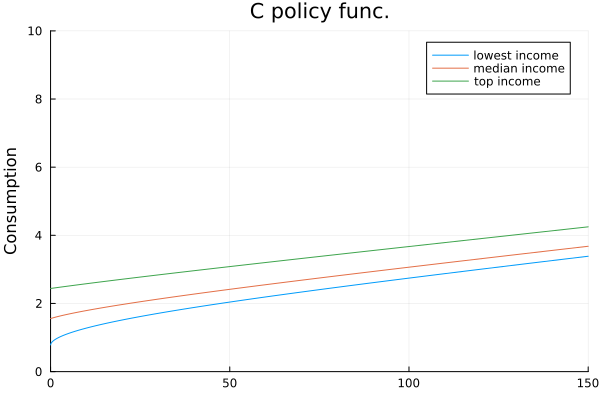

In [8]:
a = pr.a
plot(a,pr.cf[1](vec(a)), title = "C policy func.", label="lowest income", ylabel="Consumption" )
plot!(a,pr.cf[4](vec(a)), label="median income" )
plot!(a,pr.cf[7](vec(a)), label="top income" )
xlims!((0,150))
ylims!((0,10))

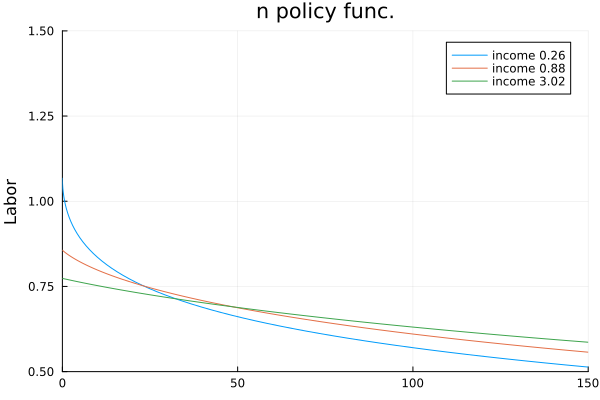

In [9]:
plot()
for i in [1,4,7]
    n = ((1-pr.τ).*pr.w.*pr.z[i] .* (pr.cf[i](vec(a))).^(-pr.σ) ).^(1/pr.γ) #labor supply today
    plot!(a,n, title = "n policy func.", label="income $(round(pr.z[i],digits=2))", ylabel="Labor" )
end
xlims!((0,150))
ylims!((0.5,1.5))

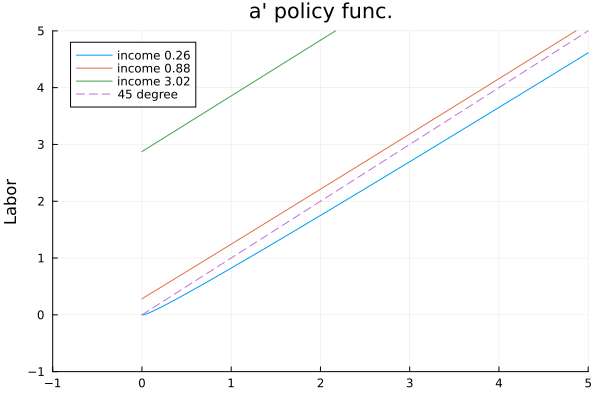

In [10]:
@unpack a_dist, z = pr
plot()
c_pol = hcat([pr.cf[s](vec(a_dist)) for s in 1:pr.nz]...)
n_pol = ( (1-pr.τ).*pr.w.*z'.* c_pol.^(-pr.σ) ).^(1/pr.γ)
a_pol = (1+pr.r).*a_dist .+ (1-pr.τ).*pr.w.*z'.*n_pol - c_pol .+ pr.T
for i in [1,4,7]
    plot!(a_dist,a_pol[:,i], title = "a' policy func.", label="income $(round(z[i],digits=2))", ylabel="Labor" )
end
xlims!((-1,5))
ylims!(-1,5)
plot!(a_dist,a_dist, style = :dash, label = "45 degree")

## Dist

In [11]:
transitionMartixMaker!(pr);
distFinder!(pr);

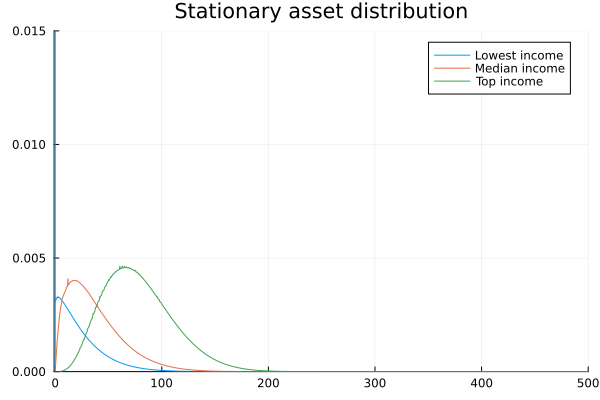

In [12]:
dist_plot = reshape(pr.dist,pr.Ia,:)./sum(pr.dist)
plot(a_dist,dist_plot[:,1] ./ sum(dist_plot[:,1]),title = "Stationary asset distribution", label = "Lowest income")
plot!(a_dist,dist_plot[:,4]./ sum(dist_plot[:,4]), label = "Median income")
plot!(a_dist,dist_plot[:,7]./ sum(dist_plot[:,7]), label = "Top income")
xlims!((-1,500))
ylims!((0,0.015))

In [13]:
@unpack dist, a_dist, z = pr
c_pol = hcat([pr.cf[s](vec(a_dist)) for s in 1:pr.nz]...)
n_pol = ( (1-pr.τ).*pr.w.*z'.* c_pol.^(-pr.σ) ).^(1/pr.γ)
z_1 = kron(z,ones(pr.Ia,1))
print("Agg K/N in this economy is: ",dot(dist,kron(ones(pr.nz,1),a_dist))/dot(dist,reshape(n_pol,:,1)) ,"\n")
print("Agg Diff in gov budget in this economy is: ",dot(pr.dist,pr.τ.*(pr.w.*z_1.*reshape(n_pol,:,1))) - pr.T )

Agg K/N in this economy is: 39.42764169735289
Agg Diff in gov budget in this economy is: 0.00021835054200353143

## Market Clearing

For market clearing, I plan to clear it once for K/N value and not once separately for K and once for N. 

In [14]:
# Capital Market Clearance target
# Trying to fin beta that GE correspond with these parameters and Gov budget satisfies constraint
K2Y  = 10.8
Y2K  = 1/K2Y
pr.δ = pr.α * Y2K - pr.r
pr.K2N = K2N = (Y2K/pr.Z)^(1/(pr.α-1)) 
pr.w = (1-pr.α)*pr.Z*K2N^pr.α
K2N

41.18362947600099

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


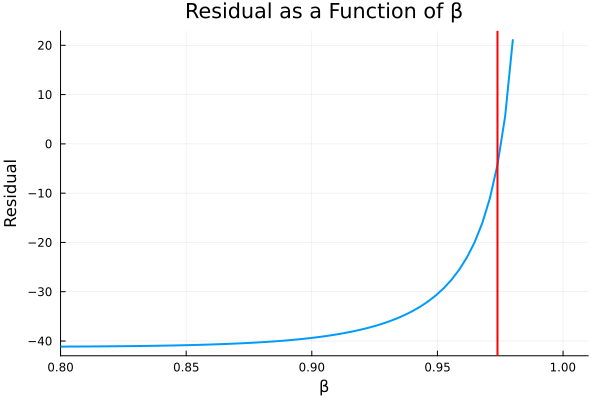

In [15]:
# Generate a grid of β values
β_grid = range(0.80, .98, length=60)  # Adjust range and step size as needed

# Initialize an array to store residuals
residuals = Vector{Float64}(undef, length(β_grid))

# Compute residuals in parallel using threads
@showprogress for i in eachindex(β_grid)
    residuals[i] = βres([β_grid[i]])
end

# Use a root-finding method to find β such that residual is zero
β_zero = β_grid[findmin(abs.(residuals))[2]]

# Plot the residuals as a function of β
plot(β_grid, residuals, xlabel="β", ylabel="Residual", title="Residual as a Function of β", lw=2, legend=false)

# Add a vertical line at β_zero
vline!([β_zero], label="β_zero", color=:red, lw=2)
xlims!((0.80, 1.01))

In [16]:
Q̄ = 1/(1+pr.r)
β= fzero(βres,(0.9,0.98))
pr.β = β
print("β = ",β)

β = 0.9753619003295896

## Finding Steady State with Tax

In [17]:
# store initial steady state values by finding beta that clears the market
find_steady_statebyβ!(pr)
pr_initial = deepcopy(pr)

The error in K/N ratio is: 5.087734677999833e-9

AiyagaryParam
  β: Float64 0.9753619012822032
  σ: Float64 5.0
  γ: Float64 10.0
  τ: Float64 0.1
  min_a: Float64 0.0
  max_a: Float64 500.0
  ϕ: Float64 2.073
  ν: Float64 1.0
  Z: Float64 1.0
  α: Float64 0.36
  δ: Float64 0.02333333333333333
  N: Float64 0.734809148285426
  K: Float64 30.262107702301364
  r: Float64 0.01
  w: Float64 2.440511376355614
  T: Float64 0.17933100923280196
  K2N: Float64 41.18362947600099
  na: Int64 99
  Ia: Int64 1000
  nz: Int64 7
  ρe: Float64 0.966
  σe: Float64 0.13
  a: Array{Float64}((100,)) [0.0, 0.002629509955623205, 0.017504264522172852, 0.05586475814587783, 0.12513432215927076, 0.23113839378709117, 0.37886855114157914, 0.5727689171492574, 0.8168865873444158, 1.1149630653460278  …  398.55459175945, 409.78033979073916, 421.1936985249249, 432.7957016636956, 444.587377274941, 456.5697478838829, 468.74383056176885, 481.110637012227, 493.6711736553698, 500.0]
  z: Array{Float64}((7,)) [0.2573837629323306, 0.3880439624488832, 0.5850334732755426, 0.8

## Tax Shock

A shock in Z(TFP) happen in t = 5 and distribution was stationary. Shock is a temporary $10%$ drop in Z and then get back to steady state with an AR(1) process.
Then I assume after $T=200$ it get back to previous before shock situation.

In [18]:
# include("src-funcs.jl")
shock = ShockParam()
shock.value = +1.        # 10 percentage point increse in tax rate from 10% to 20%

1.0

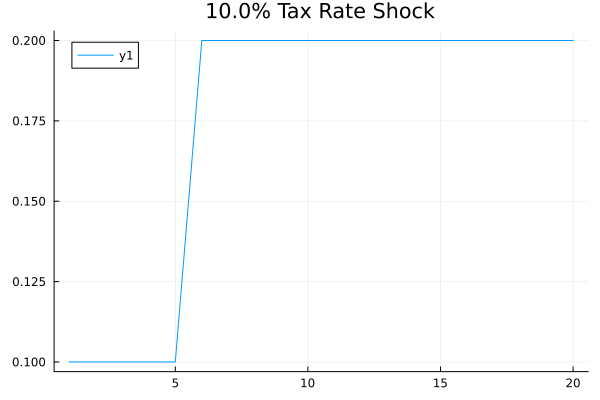

In [19]:
# shock_temp_maker!(shock)
shock_perm_maker!(shock)
plot(pr.τ .* shock.shock[1:20], title = "$(shock.value*10)% Tax Rate Shock")

In [20]:
# store final steady state values
shock_tax = pr_initial.τ .* shock.shock[shock.T]
find_steady_statebyK!(pr,shock_tax)
pr_final = deepcopy(pr)

Iteration 0: Diff K = 9.942500891137929, K2N_sup=31.241128589950794, pr.K2N_dem=37.12393680215151, T=0.35986630480547316
Iteration 1: Diff K = 0.8240031464695008, K2N_sup=37.94793994862101, pr.K2N_dem=37.63482665939534, T=0.3438708831488827
Iteration 2: Diff K = 0.7466207608822657, K2N_sup=36.88820589851307, pr.K2N_dem=37.30168072109517, T=0.3460957919244838
Iteration 3: Diff K = 0.26854125237586146, K2N_sup=37.57022197347103, pr.K2N_dem=37.430945937266806, T=0.3446532792160619
Iteration 4: Diff K = 0.1291466169652793, K2N_sup=37.30179932030153, pr.K2N_dem=37.3705819219756, T=0.34521658430278357
Iteration 5: Diff K = 0.05583007703505416, K2N_sup=37.426411999010654, pr.K2N_dem=37.39693781614876, T=0.3449541575238808
Iteration 6: Diff K = 0.024966419959184805, K2N_sup=37.37197139618957, pr.K2N_dem=37.38518879271771, T=0.3450688218075528
Iteration 7: Diff K = 0.010918427594134528, K2N_sup=37.39610722031185, pr.K2N_dem=37.39033757556768, T=0.3450177727213167
Iteration 8: Diff K = 0.0046989

AiyagaryParam
  β: Float64 0.9753619012822032
  σ: Float64 5.0
  γ: Float64 10.0
  τ: Float64 0.2
  min_a: Float64 0.0
  max_a: Float64 500.0
  ϕ: Float64 2.073
  ν: Float64 1.0
  Z: Float64 1.0
  α: Float64 0.36
  δ: Float64 0.02333333333333333
  N: Float64 0.731921067169419
  K: Float64 27.365639597589475
  r: Float64 0.012127426191786785
  w: Float64 2.3570395067607985
  T: Float64 0.34503337845612364
  K2N: Float64 37.3887852462308
  na: Int64 99
  Ia: Int64 1000
  nz: Int64 7
  ρe: Float64 0.966
  σe: Float64 0.13
  a: Array{Float64}((100,)) [0.0, 0.002629509955623205, 0.017504264522172852, 0.05586475814587783, 0.12513432215927076, 0.23113839378709117, 0.37886855114157914, 0.5727689171492574, 0.8168865873444158, 1.1149630653460278  …  398.55459175945, 409.78033979073916, 421.1936985249249, 432.7957016636956, 444.587377274941, 456.5697478838829, 468.74383056176885, 481.110637012227, 493.6711736553698, 500.0]
  z: Array{Float64}((7,)) [0.25738376293233106, 0.38804396244888384, 0.585

In [21]:
@unpack α, δ, Z, w,r,nz,σ,γ,Ia,na = pr
@unpack T = shock

Tt = pr_final.T * ones(shock.T)
τt = pr_initial.τ .* shock.shock
Kt = pr_final.K * ones(shock.T)
Nt = pr_final.N * ones(shock.T)
dists = repeat(pr_final.dist,1,shock.T+1)
Wt = similar(Nt)
Rt = similar(Nt)

Tt[1:5] .= pr_initial.T
Kt[1:5] .= pr_initial.K
Nt[1:5] .= pr_initial.N
Wt[1:5] .= pr_initial.w
Rt[1:5] .= pr_initial.r
dists[:, 1:5] .= pr_initial.dist
K2Nt = Kt ./ Nt
Wt = (1 - α) * Z * K2Nt .^ α
Rt = α * Z * K2Nt .^ (α - 1) .- δ

diffK = 1
tol = 1e-4 
iteration = 0
Ktnew = copy(Kt)

λcoefs = zeros(nz*(na+1),shock.T)
cfs = Vector{Vector{Spline1D}}(undef,shock.T)#Vector{Vector{Spline1D}}(undef,T)
λcoefs[:,1:5] .= pr_initial.λcoef #grab the λ ceoficients
cfs[1:5] .= [pr_initial.cf]
λcoefs[:,T-5:T] .= pr_final.λcoef #grab the λ ceoficients
cfs[T-5:T] .= [pr_final.cf]

while diffK > tol
    iteration += 1
    diffT = 1
    # update tax for a given capital path
    while diffT > tol
        Ttnew = copy(Tt)
        λcoefs, cfs = compute_policy_path(pr_initial, pr_final, shock, Rt, Wt, Tt, τt)
        for t in 5:shock.T-5
            @views iteratedistribution_forward!(pr,dists[:,t],dists[:,t+1], cfs[t], Rt[t], Wt[t], Tt[t], τt[t])
            c_pol = hcat([cfs[t][s](vec(a_dist)) for s in 1:nz]...)
            n_pol = ( (1-τt[t]) .* Wt[t].*z'.* c_pol.^(-σ) ).^(1/γ)
            z_1 = kron(z,ones(Ia,1))
            Ttnew[t] = dot(dists[:,t],τt[t].*(Wt[t].*z_1.*reshape(n_pol,:,1)))
        end
        diffT = norm(Ttnew .- Tt, Inf)
        Tt = (1 - 0.9) .* Tt .+ 0.9 .* Ttnew
    end
    println("Diff T = $diffT")

    # Update capital path
    Ktnew = copy(Kt)
    for t = 6:shock.T-5
        c_pol = hcat([cfs[t][s](vec(a_dist)) for s in 1:nz]...)
        n_pol = ( (1-τt[t]) .* Wt[t].*z'.* c_pol.^(-σ) ).^(1/γ)
        z_1 = kron(z,ones(Ia,1))
        Nt[t] = dot(dists[:,t],z_1.*reshape(n_pol,:,1))
        Ktnew[t] = dot(dists[:,t], kron(ones(pr.nz,1),a_dist))  
    end
    # Compute the difference between iterations
    diffK = norm(Ktnew .- Kt, Inf)
    # Relaxation step
    Kt = (1 - 0.7) .* Kt .+ 0.7 .* Ktnew
    # Update variables
    K2Nt = Kt ./ Nt
    Wt = (1 - α) * Z * K2Nt .^ α
    Rt = α * Z * K2Nt .^ (α - 1) .- δ

    println("**************************Iteration $iteration: Diff K = $diffK")
end

Diff T = 1.3259153631206555e-5
**************************Iteration 1: Diff K = 2.896468098325439
Diff T = 2.0284373966172886e-5
**************************Iteration 2: Diff K = 1.0393682674369167
Diff T = 5.2211106756572256e-5
**************************Iteration 3: Diff K = 0.7839611386537726
Diff T = 2.2994677095766747e-5
**************************Iteration 4: Diff K = 0.5628731084116261
Diff T = 1.8725856167356447e-5
**************************Iteration 5: Diff K = 0.3535768042432146
Diff T = 1.192742290234694e-5
**************************Iteration 6: Diff K = 0.21278511744123207
Diff T = 8.426845918779735e-5
**************************Iteration 7: Diff K = 0.122649128441644
Diff T = 4.824028178906925e-5
**************************Iteration 8: Diff K = 0.06922573472351345
Diff T = 2.8068985650941958e-5
**************************Iteration 9: Diff K = 0.03856632799988802
Diff T = 1.5483329463161777e-5
**************************Iteration 10: Diff K = 0.021370054979563236
Diff T = 9.97543542

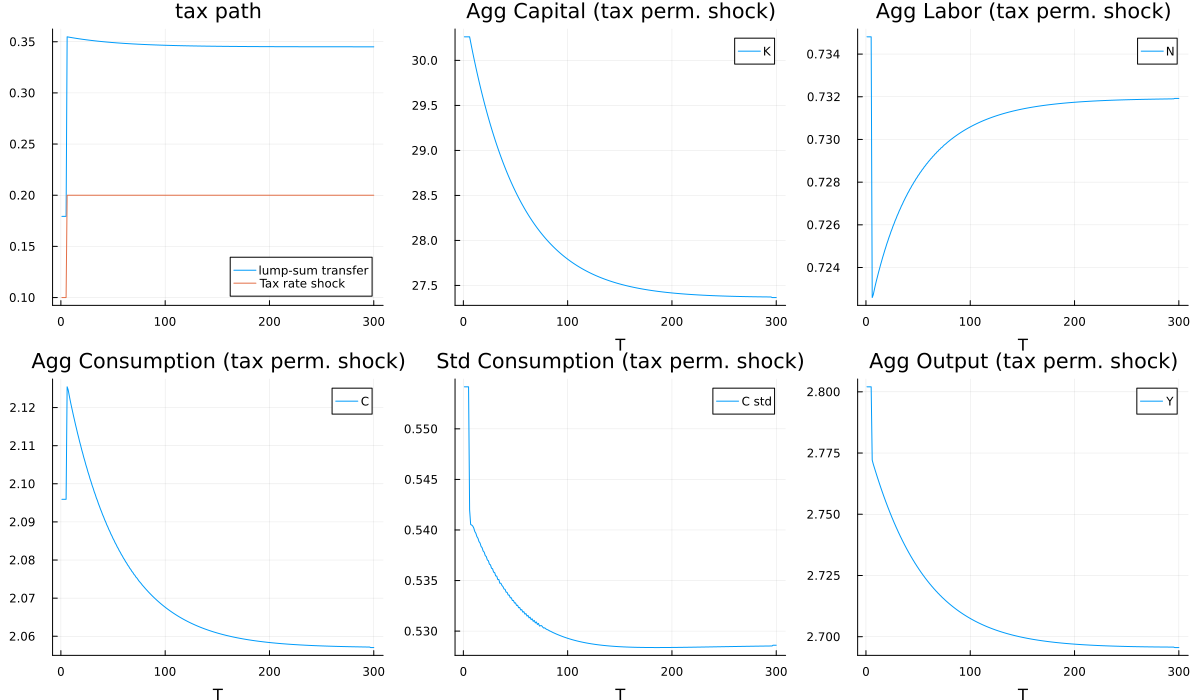

In [22]:
p_tax = plot(Tt, label = "lump-sum transfer")
plot!(p_tax,shock.shock .* pr_initial.τ, label = "Tax rate shock", title ="tax path")

p_k = plot(Kt, xlabel = "T" , title = "Agg Capital (tax perm. shock)", label = "K")

p_n = plot(Nt, xlabel = "T" , title = "Agg Labor (tax perm. shock)", label = "N")

Ct = similar(Kt)
C_stdt = similar(Kt)
for t in 1:shock.T
    c = vcat([cfs[t][s].(vec(pr.a_dist)) for s in 1:pr.nz]...)
    Ct[t] = dot(c,dists[:,t])
    C_stdt[t] = std(c, weights(dists[:,t]))
end
p_c = plot(Ct, xlabel = "T" , title = "Agg Consumption (tax perm. shock)", label = "C")
p_cstd = plot(C_stdt, xlabel = "T" , title = "Std Consumption (tax perm. shock)", label = "C std")

Yt = pr.Z * Kt.^(pr.α) .* Nt.^(1-pr.α)
p_y = plot(Yt, xlabel = "T" , title = "Agg Output (tax perm. shock)", label = "Y")

plot(p_tax, p_k, p_n, p_c, p_cstd, p_y, layout=(2,3),size=(1200,700))

### Welfare

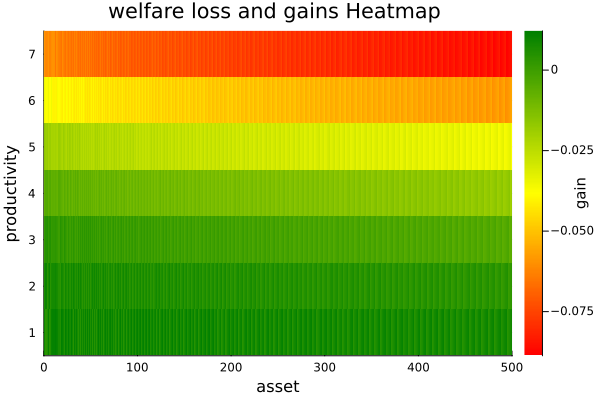

In [24]:
# compute value function at initial SS
V_initial = valuefunction_calculator(pr_initial,pr)

# compute value function at final SS
V_final = valuefunction_calculator(pr_final,pr)

# compute value function of shock 
V_shock = V_final
for t in reverse(5:shock.T)
    c = hcat([cfs[t][s].(vec(pr.a_dist)) for s in 1:pr.nz]...)
    V_shock = u.(c,[pr]) .+ β.*V_shock
end

welfare_c = uinv.(V_shock,[pr]) - uinv.(V_final,[pr])

green_to_red = cgrad([:red, :yellow, :green])
heatmap(pr.a_dist, 1:pr.nz, welfare_c, c=green_to_red, colorbar_title="gain", xlabel="asset", ylabel="productivity", title="welfare loss and gains Heatmap ")
